### Import Libraries

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import importlib
import os
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import utils

### Read dataset and aggregate the data per game

In [40]:
utils = importlib.reload(utils)

path = 'data/MLB_AtBats_RegularSeason_2012.csv'

df = pd.read_csv( path, low_memory=False)
X, y = utils.split_by_game(df)

key_columns = ['date', 'visitor', 'home', 'stadium']
matches = df.groupby( key_columns)
Xpreproc = df.groupby(key_columns)
Xpreproc = [list(k) for k, _ in matches]
Xpreproc = pd.DataFrame(Xpreproc, columns=key_columns)

### Baseline model:

Compute the accumulated probability of each team to win. This baseline considers the number of runs made by each team before the current game. For simplicity, we precompute these values.

In [41]:
from datetime import date

all_teams = set(Xpreproc.home.values) | set(Xpreproc.visitor.values)
team_runs = {t: 0 for t in all_teams}
team_neg_runs = {t: 0 for t in all_teams}
games_count = {t: 0 for t in all_teams}
games_win = {t: 0 for t in all_teams}
last_game_date = {t: None for t in all_teams}
pitcher_home = ['' for x in X]
pitcher_visitor = ['' for x in X]

pos_runs_home = np.zeros(len(X))
neg_runs_home = np.zeros(len(X))
pos_runs_visitor = np.zeros(len(X))
neg_runs_visitor = np.zeros(len(X))
home_counter = np.zeros(len(X))
visitor_counter = np.zeros(len(X))
rest_days_home = np.nan * np.zeros(len(X))
rest_days_visitor = np.nan * np.zeros(len(X))

wins_home = np.zeros(len(X))
wins_visitor = np.zeros(len(X))

home_prob = np.zeros(len(X))

for i in range(Xpreproc.shape[0]):
    home = Xpreproc.iloc[i].home
    visitor = Xpreproc.iloc[i].visitor
    home_score = X[i].home_score.values.max()
    visitor_score = X[i].away_score.values.max()
    next_date = list(map(int, X[i].date.values[0].split('-')))
    
    home_prob[i] = float(team_runs[home]) / max(1, float(team_runs[home] + team_runs[visitor]))

    pos_runs_home[i] = float(team_runs[home])
    neg_runs_home[i] = float(team_neg_runs[home])
    pos_runs_visitor[i] = float(team_runs[visitor])
    neg_runs_visitor[i] = float(team_neg_runs[visitor])
    home_counter[i] = float(games_count[home])
    visitor_counter[i] = float(games_count[visitor])
    wins_home[i] = float(games_win[home] + 1) / (games_count[home] + 1)
    wins_visitor[i] = float(games_win[visitor] + 1) / (games_count[visitor] + 1)

    pitcher_home[i] = X[i].pitcher.values[X[i].side == 'top'][0]
    pitcher_visitor[i] = X[i].pitcher.values[X[i].side == 'bottom'][0]

    # This is not being used. The teams play almost every day so it's not giving good results
    if last_game_date[home] is not None:
        rest_days_home[i] = (date(*next_date) - date(*last_game_date[home])).days
    if last_game_date[visitor] is not None:
        rest_days_visitor[i] = (date(*next_date) - date(*last_game_date[visitor])).days

    team_runs[home] += home_score
    team_runs[visitor] += visitor_score

    team_neg_runs[home] += visitor_score
    team_neg_runs[visitor] += home_score

    games_count[home] += 1.
    games_count[visitor] += 1.
    games_win[home] += 1 if home_score > visitor_score else 0
    games_win[visitor] += 1 if home_score < visitor_score else 0

    last_game_date[home] = next_date
    last_game_date[visitor] = next_date

Xpreproc['home-prob'] = home_prob
Xpreproc['home-pos-runs'] = pos_runs_home
Xpreproc['home-neg-runs'] = neg_runs_home
Xpreproc['visitor-pos-runs'] = pos_runs_visitor
Xpreproc['visitor-neg-runs'] = neg_runs_visitor
Xpreproc['home-games-played'] = home_counter
Xpreproc['visitor-games-played'] = visitor_counter
Xpreproc['home-win'] = wins_home
Xpreproc['visitor-win'] = wins_visitor
Xpreproc['home-rest-days'] = rest_days_home
Xpreproc['visitor-rest-days'] = rest_days_visitor
Xpreproc['home-stadium'] = ['%s-%s' % (a, b) for a, b in zip(Xpreproc['home'].values, Xpreproc['stadium'].values)]
Xpreproc['pitcher-home'] = pitcher_home
Xpreproc['pitcher-visitor'] = pitcher_visitor

# New code

## Preprocessing
Adding new parameters and reparing old ones

First let's copy current data and add end result (our targer -> 'result').
There is also a display how much matches are wrong, but it turn out that model fits better if we leave wrong labeled data in dataset.

In [42]:
data = Xpreproc.copy()

score = df.groupby(['date', 'visitor', 'home', 'stadium'])['home_score', 'away_score'].max()
score[ 'result'] = score[ 'home_score'] - score[ 'away_score']
score.drop( 'home_score', axis=1, inplace=True)
score.drop( 'away_score', axis=1, inplace=True)

data = data.join( score, on=['date', 'visitor', 'home', 'stadium'])
print('count of void matches: ', len (data[ data['result'] == 0]))

# UNCOMMENT THIS TO REMOVE WRONG DATA
# dropping all row's where result is equal to 0 (this is not possible in baseball)
data.drop( np.where( data['result'] == 0)[0], axis=0, inplace=True)

data['result'] = data['result'] > 0

count of void matches:  176


Our data is represented over time (summing previous results with the new ones). So if we want to compare the beginning of the season with the end of the season, we must first normalize the data by the cound of matches already played.

In [43]:
def normalize_by_game(df, columns, norm):
    for feature in columns:
        df[ feature] = df[ feature] / df[ norm]
    return df

At the start of the season, all teams are well rested, this is why we setted them largest rest time in a season.

In [44]:
# setting missing data of rest days to max
max_rest = max( data[ 'home-rest-days'].dropna())
data[ 'home-rest-days'] = data[ 'home-rest-days'].fillna( max_rest)
data[ 'visitor-rest-days'] = data[ 'visitor-rest-days'].fillna( max_rest)

Representing new attributes: home-inning-len, visitor-inning-len. Which describes average inning-len across played matches. In one match we sum length of all innings. That is inning-len per match.

In [45]:
# average inning time home and away
inning_columns = ['date', 'visitor', 'home', 'stadium', 'side']
inning_df = df.groupby( inning_columns).size()
inning_df = inning_df.reset_index()
inning_df = inning_df.rename(columns={0: 'inning_length'})

# summing length of innings
home = inning_df[ inning_df['side'] == 'top'].groupby(['date' ,'visitor', 'home', 'stadium'])[ 'inning_length'].sum()
away = inning_df[ inning_df['side'] == 'bottom'].groupby(['date' ,'visitor', 'home', 'stadium'])[ 'inning_length'].sum()

home = home.to_frame()
away = away.to_frame()

data = data.join(home, on=['date', 'visitor', 'home', 'stadium'])
data = data.rename( columns={'inning_length': 'home-inning-sub'})

data = data.join(away, on=['date', 'visitor', 'home', 'stadium'])
data = data.rename( columns={'inning_length': 'visitor-inning-sub'})

del home, away

In [46]:
def drop_team_columns_ending(data, all_teams, ending=''):
    for team in all_teams:
        data.drop( team + ending, axis=1, inplace=True)
    return data

In [47]:
'''
Creating team inning average combining both home and away games. 
Data is shifted so its known after each game then applying the cumulative sum 
from which we will calculate average inning length.
'''
for team in all_teams:
    mask = data['home'] == team
    tname = str(team + '-inning-len')

    data[ tname] = 0
    data.iloc[ np.where( mask)[0], data.columns.get_loc( tname)] += data['home-inning-sub']
    
    mask = data['visitor'] == team
    data.iloc[ np.where( mask)[0], data.columns.get_loc( tname)] += data['visitor-inning-sub']
    data[ tname] = data[ tname].shift().fillna( 0)
    data[ tname] = data[ tname].cumsum()

# creating new features
data[ 'home-inning-len'] = data.apply( lambda x: x[ x['home'] + '-inning-len'], axis=1)
data[ 'visitor-inning-len'] = data.apply( lambda x: x[ x['visitor'] + '-inning-len'], axis=1)

data = drop_team_columns_ending( data, all_teams, ending='-inning-len')
# dropping all unnececery columns
#for team in all_teams:
#    data.drop( team + '-inning-len', axis=1, inplace=True)

Adding last game feature [0 -> if previus game was lost, 1-> if previus game was win]

In [48]:
def convert_result( res):
    '''
    Converting True, False resutlts to 1 and 0 so the initial stat can be 0.5
    '''
    if pd.isnull(res):
        return 0.5
    if res:
        return 1
    return 0

In [49]:
def last_game_attribute( data, all_teams):
    for team in all_teams:
        tname = team + '-last-game'

        data[ tname] = pd.np.nan

        home_mask = data[ 'home'] == team
        data.iloc[ np.where( home_mask)[0], data.columns.get_loc( tname)] = data[ 'result']
        away_mask = data[ 'visitor'] == team
        data.iloc[ np.where( away_mask)[0], data.columns.get_loc( tname)] = data[ 'result'].apply( lambda x: not x)

        data[ tname] = data[ tname].shift().fillna( method='pad')
        data[ tname] = data[ tname].apply( lambda x: convert_result( x))

    data[ 'home-last-game'] = data.apply( lambda x: x[ x[ 'home'] + '-last-game'], axis=1)
    data[ 'visitor-last-game'] = data.apply( lambda x: x[ x[ 'visitor'] + '-last-game'], axis=1)

    data = drop_team_columns_ending( data, all_teams, '-last-game')
    return data

In [50]:
data = last_game_attribute( data, all_teams)

In [51]:
data

,date,visitor,home,stadium,home-prob,home-pos-runs,home-neg-runs,visitor-pos-runs,visitor-neg-runs,home-games-played,...,home-stadium,pitcher-home,pitcher-visitor,result,home-inning-sub,visitor-inning-sub,home-inning-len,visitor-inning-len,home-last-game,visitor-last-game
0,2012-03-28,SEA,OAK,Tokyo Dome,0.000000,0.0,0.0,0.0,0.0,0.0,...,OAK-Tokyo Dome,McCarthy_Brandon_435221,Hernandez_Felix_433587,False,40,41,0.0,0.0,0.5,0.5
1,2012-03-29,SEA,OAK,Tokyo Dome,0.250000,1.0,3.0,3.0,1.0,1.0,...,OAK-Tokyo Dome,Colon_Bartolo_112526,Vargas_Jason_450306,True,31,32,40.0,41.0,0.0,1.0
2,2012-04-04,STL,MIA,Marlins Park,0.000000,0.0,0.0,0.0,0.0,0.0,...,MIA-Marlins Park,Johnson_Josh_435178,Lohse_Kyle_346798,False,41,31,0.0,0.0,0.5,0.5
3,2012-04-05,ATL,NYM,Citi Field,0.000000,0.0,0.0,0.0,0.0,0.0,...,NYM-Citi Field,Santana_Johan_276371,Hanson_Tommy_462102,True,34,34,0.0,0.0,0.5,0.5
5,2012-04-05,LAD,SD,Petco Park,0.000000,0.0,0.0,0.0,0.0,0.0,...,SD-Petco Park,Volquez_Edinson_450172,Kershaw_Clayton_477132,False,39,34,0.0,0.0,0.5,0.5
6,2012-04-05,MIA,CIN,Great American Ball Park,0.000000,0.0,0.0,1.0,4.0,0.0,...,CIN-Great American Ball Park,Cueto_Johnny_456501,Buehrle_Mark_279824,True,31,38,0.0,41.0,0.5,0.0
7,2012-04-05,PHI,PIT,PNC Park,0.000000,0.0,0.0,0.0,0.0,0.0,...,PIT-PNC Park,Bedard_Erik_407853,Halladay_Roy_136880,False,35,30,0.0,0.0,0.5,0.5
8,2012-04-05,TOR,CLE,Progressive Field,0.000000,0.0,0.0,0.0,0.0,0.0,...,CLE-Progressive Field,Masterson_Justin_475416,Romero_Ricky_460069,False,65,64,0.0,0.0,0.5,0.5
9,2012-04-05,WSH,CHC,Wrigley Field,0.000000,0.0,0.0,0.0,0.0,0.0,...,CHC-Wrigley Field,Dempster_Ryan_133225,Strasburg_Stephen_544931,False,38,34,0.0,0.0,0.5,0.5
10,2012-04-06,COL,HOU,Minute Maid Park,0.000000,0.0,0.0,0.0,0.0,0.0,...,HOU-Minute Maid Park,Rodriguez_Wandy_434643,Guthrie_Jeremy_425386,False,41,35,0.0,0.0,0.5,0.5


## Normalization
In this section, we need to change all categorical features into labelled features and normalize all numeric features using mean, std normalization. But because of cumulative sums in data, it is good to normalize them with normalize_by_game function so data can be compared.

In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
# labeling categorical features with LabelEncoder()
categorical_features = [['home', 'visitor'], ['stadium'], ['pitcher-home', 'pitcher-visitor']]

for section in categorical_features:
    encoder = LabelEncoder()
    encoder.fit( np.concatenate([ data[ feature] for feature in section]))
    
    for feature in section:
        data[ feature] = encoder.transform( data[ feature])


In [58]:
# DONT USE IT FOR BETTER RESULTS
# normalizing features by day so we can compare them over time
data = normalize_by_game( data, ['home-pos-runs', 'home-neg-runs', 'home-inning-len'], 'home-games-played')
data = normalize_by_game( data, ['visitor-pos-runs', 'visitor-neg-runs', 'visitor-inning-len'], 'visitor-games-played')

In [59]:
# DONT USE IT FOR BETTER RESULTS!
# normal normalizing of numeric features 
numeric_features = ['home-pos-runs', 'home-neg-runs', 'visitor-pos-runs', 'visitor-neg-runs',
                   'home-inning-len', 'visitor-inning-len']

for feature in numeric_features:
    fmean = data[ feature].mean()
    fstd = data[ feature].std()
    data[ feature] = ( data[ feature] - fmean) / fstd
    data[ feature] = data[ feature].fillna( 0)

It is strange that normalization does not help model to get better results

## Vizualization

In [54]:
import plotly.plotly as py
import plotly.graph_objs as go

Vizualising home positive runs vs visitor positive runs. You can get 2 different outputs: one with normalize_by_game and one without it. But it's clear that we can not determen which team will win only by looking at those two attributes.

In [55]:
home_win_data = data[ data['result']]
away_win_data = data[ data['result'].map(lambda x: not x) ]

home_win = go.Scatter(
    x = home_win_data[ 'home-pos-runs'],
    y = home_win_data[ 'visitor-pos-runs'],
    name = 'Home win',
    mode = 'markers'
)

away_win = go.Scatter(
    x = away_win_data[ 'home-pos-runs'],
    y = away_win_data[ 'visitor-pos-runs'],
    name = 'Visitor win',
    mode = 'markers'
)

plot = [home_win, away_win]

layout = dict(title = 'Comparing win runes of home and visitor team')

fig = dict(data=plot, layout=layout)
iplot(fig, filename='styled-scatter')

One good thing to do is to look at the win ratio of home and visitor teams. 

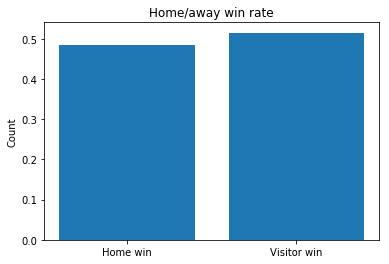

In [56]:
wins = sum( data[ 'result'])
games = len( data[ 'result'])

plt.bar([0, 1], [wins/games, (games-wins)/games])
plt.xticks([0, 1], ['Home win', 'Visitor win'])
plt.title("Home/away win rate")
plt.ylabel("Count")
plt.show()

Also let's look if previus game attribut helps to determen which team will win. 

In [39]:
home_res = data[ data['result'] == True].groupby( 'home-last-game').size()
away_res = data[ data['result'] == False].groupby( 'visitor-last-game').size()

previous_win = go.Bar(
    x=['Home win', 'Visitor win'],
    y=[home_res[1], away_res[1]],
    name='Previous win'
)
previous_loss = go.Bar(
    x=['Home win', 'Visitor win'],
    y=[home_res[0], away_res[0]],
    name='Previous loss'
)

plot_data = [previous_win, previous_loss]
layout = go.Layout(
    barmode='stack',
    title = 'Comparing win results based on previous match'
)

fig = go.Figure(data=plot_data, layout=layout)
iplot(fig, filename='stacked-bar')

## Evaluation

In [105]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline
from sklearn import metrics



from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [73]:
# Used features in learning
features = ['home-prob', 'home-pos-runs', 'home-neg-runs', 'visitor-pos-runs', 'visitor-neg-runs',
            'home-win', 'visitor-win', 'home-games-played', 'visitor-games-played', #'pitcher-home', #'pitcher-visitor',
            # 'home-inning-len', 'visitor-inning-len',
            'home-last-game', 'visitor-last-game',
            'home-rest-days', 'visitor-rest-days']

First let run and check scores of some classifiers to see which one preforms best!

In [74]:
X = data[ features].as_matrix()
y = data[ 'result']

n_split = int( len( X) * 0.8)
X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

classifiers = [LogisticRegressionCV(), LogisticRegression(), RandomForestClassifier(), SVC(), 
               KNeighborsClassifier(), GaussianProcessClassifier(), AdaBoostClassifier()]

print( 'testing classifiers')
for classifier in classifiers:
    # pred = cross_val_predict( classifier, X, y_, cv=5)
    classifier = classifier.fit(X_train, y_train)
    pred = classifier.predict( X_test)
    print( 'classifier: ', classifier)
    print( 'accuracety: ', metrics.accuracy_score( y_test, pred))
    print( 'ROC score: ', metrics.roc_auc_score(y_test, pred))
    print()


testing classifiers
classifier:  LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)
accuracety:  0.55
ROC score:  0.5455026455026455

classifier:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracety:  0.5479166666666667
ROC score:  0.5404761904761904

classifier:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            mi

In [75]:
import pickle
import os

In [76]:
def create_random_parameters( parameter_space):
    parameters = {}
    
    for key, values in parameter_space.items():
        if key.endswith('-type') or key.endswith('-convertor'): continue
        
        if parameter_space[ key + '-type'] == 'numeric':
            min_value, max_value = min( values), max( values)
            parameters[ key] = np.random.uniform(low = min_value, high=max_value)
            
            if key + '-convertor' in parameter_space:
                parameters[ key] = parameter_space[ key+'-convertor']( parameters[key])
            
        elif parameter_space[ key + '-type'] == 'categoric':
            parameters[ key] = np.random.choice( parameter_space[ key])
            
    return parameters

Parameter space describes what we want to search (in what space). There are two types of parameters: categoric and numeric. In numeric parameters, the parameter will be chosen between min and max value of the parameter. In categoric parameters, there is just a random pick of listed items.

In [19]:
parameter_space = {
    'Cs': [5, 15],
    'tol': [0.001, 0.0001],
    'max_iter': [1000],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    
    'Cs-type': 'numeric',
    'intercept_scaling-type': 'numeric',
    'tol-type': 'numeric',
    'fit_intercept-type': 'categoric',
    'solver-type': 'categoric',
    'max_iter-type': 'categoric',
    
    'Cs-convertor': int,
}
parameters = create_random_parameters( parameter_space)

In hyper-parameter search optimization we want to keep track of all tested models so there are no duplicates. Because of that, there is previous_data attribute in which we can pass previous results. Parameters are hashed 

In [20]:
def estimator_optimization(X_train, X_test, y_train, y_test, 
                           estimator, parameters_space, previous_data=None, 
                           n_models=100, display=True):
    data = previous_data if previous_data != None else {}
    
    for model_index in range( n_models):
        parameters = create_random_parameters( parameters_space)
        hsh = hash( frozenset( parameters.items()))
        
        if hsh in data: continue
        
        if display: print( 'training model with parameters:\n', 
                 '\n'.join( [param + ': ' + str(value) for param, value in parameters.items()]))
        
        # parameters[ 'verbose'] = 1
        model = estimator( **parameters)
        # pred = cross_val_predict(model, X, y, cv=5)
        model = model.fit(X_train, y_train)
        pred = model.predict_proba( X_test)[:, 1]
        
        accuracy = metrics.accuracy_score( y_test, pred > 0.5)

        if display:
            print( 'accuracy: ', accuracy)
            print()
        
        data[ hsh] = {
            'accuracety': accuracy,
            'parameters': parameters,
            'predictions': pred
        }
        
    return data
    

Running random hyper-parameter search. 

1. Load existing search results if there is some 
2. Running search optimization on 'features' in data

In [25]:
hyper_parameter_file = 'hyperparameter optimization.pkl'
if os.path.exists( hyper_parameter_file):
    with open( hyper_parameter_file, 'rb') as file:
        hp_resutls = pickle.load( file)
else:
    hp_resutls = None

ln = len( hp_resutls) if hp_resutls != None else 0
print( 'There currently exists: ', ln, ' tested models')

There currently exists:  405  tested models


In [203]:
opt_X = data[ features].as_matrix()
opt_y = data['result']
    
n_train = int( len( X) * 0.8)

X_train, X_test = opt_X[:n_train], opt_X[n_train:]
y_train, y_test = opt_y[:n_train], opt_y[n_train:]

hp_resutls = estimator_optimization(
    X_train, X_test, y_train, y_test,
    LogisticRegressionCV, 
    parameter_space, 
    previous_data=hp_resutls, 
    n_models=200
)

training model with parameters:
 Cs: 7
tol: 0.00017231652441224745
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 14
tol: 0.0006938931363740669
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 7
tol: 0.000909819448906229
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55625

training model with parameters:
 Cs: 6
tol: 0.0005312105710348979
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55

training model with parameters:
 Cs: 11
tol: 0.0008487556309085662
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.5395833333333333

training model with parameters:
 Cs: 5
tol: 0.0002658039959454323
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 13
tol: 0.0008998141915859184
max_iter: 1000
fit_intercept: True
solver: sag
accuracy:  0.5625

training

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5666666666666667

training model with parameters:
 Cs: 8
tol: 0.0009202311121527104
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.0007837918211389618
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.0006833551265382187
max_iter: 1000
fit_intercept: False
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 10
tol: 0.0009022353829625779
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5395833333333333

training model with parameters:
 Cs: 10
tol: 0.0009632124249940039
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55625

training model with parameters:
 Cs: 6
tol: 0.0007063728630647597
max_iter: 1000
fit_intercept: False
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5645833333333333

training model with parameters:
 Cs: 6
tol: 0.00048414354341532834
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 11
tol: 0.0007963517668135198
max_iter: 1000
fit_intercept: True
solver: sag
accuracy:  0.56875

training model with parameters:
 Cs: 14
tol: 0.0008021552635033405
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.5479166666666667

training model with parameters:
 Cs: 9
tol: 0.00021758885114878622
max_iter: 1000
fit_intercept: False
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5666666666666667

training model with parameters:
 Cs: 5
tol: 0.00033208554169018823
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5479166666666667

training model with parameters:
 Cs: 8
tol: 0.0009239432821516915
max_iter: 1000
fit_intercept: True
solver: sag
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 10
tol: 0.0007469905039281554
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 8
tol: 0.0006346590723411337
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.55625

training model with parameters:
 Cs: 8
tol: 0.000695413395982548
max_iter: 1000
fit_intercept: False
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 13
tol: 0.00041064595965414034
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.00047344668030530984
max_iter: 1000
fit_intercept:

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.55625

training model with parameters:
 Cs: 9
tol: 0.0005965544821984146
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5625

training model with parameters:
 Cs: 13
tol: 0.0001332498534072085
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 9
tol: 0.00048597759410223644
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 11
tol: 0.000815038943435735
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.0007589329480295054
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.5416666666666666

training model with parameters:
 Cs: 8
tol: 0.0005115354740751329
max_iter: 1000
fit_intercept: True
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5604166666666667

training model with parameters:
 Cs: 11
tol: 0.000983984180530405
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5625

training model with parameters:
 Cs: 13
tol: 0.0007639623133841961
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.54375

training model with parameters:
 Cs: 10
tol: 0.0008692137243843488
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 7
tol: 0.0004073866225637065
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5625

training model with parameters:
 Cs: 12
tol: 0.00018137214043749026
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 8
tol: 0.0008164983628891929
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 10
tol: 0.00029951353492928295
max_iter: 1000
fit_intercept: True


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5583333333333333

training model with parameters:
 Cs: 9
tol: 0.0008639521345806613
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 9
tol: 0.00016741311493804329
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5395833333333333

training model with parameters:
 Cs: 9
tol: 0.0006639569453418511
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5395833333333333

training model with parameters:
 Cs: 12
tol: 0.0008528064652140866
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 13
tol: 0.0008843542498525878
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5541666666666667

training model with parameters:
 Cs: 6
tol: 0.0004858685068383595
max_iter: 1000
fit_intercept: False
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 10
tol: 0.0004571203178295556
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5666666666666667

training model with parameters:
 Cs: 9
tol: 0.0009829351072141467
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 11
tol: 0.0007118528319331759
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 13
tol: 0.00013437993034772248
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.54375

training model with parameters:
 Cs: 13
tol: 0.00011339091190404457
max_iter: 1000
fit_intercept: False
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.56875

training model with parameters:
 Cs: 9
tol: 0.0004445695191204434
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.55

training model with parameters:
 Cs: 14
tol: 0.0005915761523363842
max_iter: 1000
fit_intercept: True
solver: newton-cg


/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuracy:  0.5458333333333333

training model with parameters:
 Cs: 12
tol: 0.0002521314334511959
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 13
tol: 0.0004036762984144104
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 11
tol: 0.000719915809926979
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5625

training model with parameters:
 Cs: 11
tol: 0.0003977911640414586
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5395833333333333

training model with parameters:
 Cs: 14
tol: 0.0009454500148367401
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 14
tol: 0.0004477042020445247
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.55625

training model with parameters:
 Cs: 8
tol: 0.0006049093376614273
max_iter: 1000
fit_int

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.55625

training model with parameters:
 Cs: 13
tol: 0.0003588857391876989
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 11
tol: 0.0008582852276589531
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5625

training model with parameters:
 Cs: 5
tol: 0.000407372250918922
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 14
tol: 0.0008741102247765722
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 11
tol: 0.000514163764605976
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.0008053349386245616
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5625

training model with parameters:
 Cs: 6
tol: 0.0007564594331975263
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.56875

training model with parameters:
 Cs: 6
tol: 0.00023285039310761167
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.54375

training model with parameters:
 Cs: 8
tol: 0.00040732348256484753
max_iter: 1000
fit_intercept: True
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5583333333333333

training model with parameters:
 Cs: 8
tol: 0.0009965343898278825
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.55625

training model with parameters:
 Cs: 6
tol: 0.0005967793470883927
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.54375

training model with parameters:
 Cs: 14
tol: 0.0007094497847843288
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 13
tol: 0.0004953227832074138
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5625

training model with parameters:
 Cs: 6
tol: 0.0009176563099861096
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 11
tol: 0.00026255149720761566
max_iter: 1000
fit_intercept: False
solver: newton-cg


/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuracy:  0.5625

training model with parameters:
 Cs: 5
tol: 0.0006500004576884049
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 12
tol: 0.00041528849688438687
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 14
tol: 0.00033963499443478566
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.55625

training model with parameters:
 Cs: 8
tol: 0.0007649891524243623
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.5375

training model with parameters:
 Cs: 9
tol: 0.0009668402092553767
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 13
tol: 0.0009770600727288525
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 13
tol: 0.0005399024140336991
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.54375

training model with parameters:
 Cs: 11
tol: 0.0005338925426052765
max_iter: 1000
fit_intercept: True
solver: liblinear
a

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5604166666666667

training model with parameters:
 Cs: 12
tol: 0.00039114126856885776
max_iter: 1000
fit_intercept: False
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 11
tol: 0.000565738723389625
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 8
tol: 0.0006538981694793589
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.55625

training model with parameters:
 Cs: 6
tol: 0.0002751259213037481
max_iter: 1000
fit_intercept: True
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5645833333333333

training model with parameters:
 Cs: 7
tol: 0.0009217207955859528
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55625

training model with parameters:
 Cs: 10
tol: 0.0007766011416567779
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5625

training model with parameters:
 Cs: 6
tol: 0.0002976584941923077
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5625

training model with parameters:
 Cs: 8
tol: 0.0009541035889140347
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 11
tol: 0.0009033951097694679
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 7
tol: 0.00035095273369107043
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 14
tol: 0.0003599661367950779
max_iter: 1000
fit_intercept: False
solver: lbfgs


/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


accuracy:  0.5416666666666666

training model with parameters:
 Cs: 11
tol: 0.0006918915857884685
max_iter: 1000
fit_intercept: False
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 13
tol: 0.000680339959783732
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.54375

training model with parameters:
 Cs: 7
tol: 0.0007758557608957648
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.55

training model with parameters:
 Cs: 5
tol: 0.0006062004452423536
max_iter: 1000
fit_intercept: True
solver: newton-cg


/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


accuracy:  0.5416666666666666

training model with parameters:
 Cs: 6
tol: 0.0006623869420213354
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.54375

training model with parameters:
 Cs: 9
tol: 0.0004455777967940214
max_iter: 1000
fit_intercept: False
solver: newton-cg


/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuracy:  0.55

training model with parameters:
 Cs: 13
tol: 0.0007304758848526423
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 5
tol: 0.0005057291824045742
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.0006694573028448606
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.5416666666666666

training model with parameters:
 Cs: 12
tol: 0.0006486411617154827
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 13
tol: 0.00034700613153376486
max_iter: 1000
fit_intercept: True
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 8
tol: 0.00040786232798131295
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.55625

training model with parameters:
 Cs: 11
tol: 0.0007892861295545879
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5625

training model with parameters:
 Cs: 8
tol: 0.0004254706057159819
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 14
tol: 0.0001585718341249826
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 6
tol: 0.0002850638288556082
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 14
tol: 0.00041346737468204173
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5604166666666667

training model with parameters:
 Cs: 12
tol: 0.0003881516079042916
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5541666666666667

training model with parameters:
 Cs: 12
tol: 0.0002847544038189799
max_iter: 1000
fit_intercept: False
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 12
tol: 0.00038232512108351895
max_iter: 1000
fit_intercept: False
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 8
tol: 0.0008847885915309937
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.55625

training model with parameters:
 Cs: 9
tol: 0.0009714007578002144
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.55

training model with parameters:
 Cs: 6
tol: 0.0008682040497326978
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.55

training model with parameters:
 Cs: 13
tol: 0.0006779569285808766
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.54375

training model with parameters:
 Cs: 10
tol: 0.0006673991264405766
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.0008886244286053371
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.5416666666666666

training model with parameters:
 Cs: 7
tol: 0.0007904996699428084
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55625

training mo

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 6
tol: 0.0006762495439681858
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 10
tol: 0.0001984607032213508
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55625

training model with parameters:
 Cs: 10
tol: 0.0006638253741093258
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 12
tol: 0.0009611049396109298
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.5395833333333333

training model with parameters:
 Cs: 8
tol: 0.00023311526600002468
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.55625

training model with parameters:
 Cs: 14
tol: 0.0008660212840094352
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 13
tol: 0.00043204896794951685
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 6
tol: 0.0005864920455052286
max_iter: 1000
fit_intercept: True
solver: newton-cg
accuracy:  0.54375

training model with parameters:
 Cs: 9
tol: 0.0003214245990628116
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 11
tol: 0.0006355727210067089
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 7
tol: 0.0007438340572471438
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5625

training model with parameters:
 Cs: 13
tol: 0.0006530174549864023
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5625

training model with parameters:
 Cs: 9
tol: 0.0003335619654283459
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5666666666666667

training model with parameters:
 Cs: 13
tol: 0.0008102016582543201
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 10
tol: 0.000526566829520754
max_iter: 1000
fit_intercept: False
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 13
tol: 0.0006453702652736178
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.54375

training model with parameters:
 Cs: 6
tol: 0.0002931181049701354
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55

training model with parameters:
 Cs: 5
tol: 0.0009479354946432983
max_iter: 1000
fit_intercept: True
solver: newton-cg


/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/Frenkie/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


accuracy:  0.5416666666666666

training model with parameters:
 Cs: 14
tol: 0.0009441822023860725
max_iter: 1000
fit_intercept: True
solver: sag
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 10
tol: 0.00011479208807664057
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 14
tol: 0.00025166197440990473
max_iter: 1000
fit_intercept: False
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 14
tol: 0.0007753131701054492
max_iter: 1000
fit_intercept: True
solver: saga
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 6
tol: 0.0007173081905555683
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55

training model with parameters:
 Cs: 10
tol: 0.0009101053730075897
max_iter: 1000
fit_intercept: False
solver: saga
accuracy:  0.56875

training model with parameters:
 Cs: 14
tol: 0.0006629382050948086
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.5604166666666667

training model with parameters:
 Cs: 11
tol: 0.0009324047033708078
max_iter: 1000
fit_intercept: False
solver: saga
accuracy:  0.56875

training model with parameters:
 Cs: 7
tol: 0.0007393042494631967
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 13
tol: 0.0004630678238472582
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.55833333333

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 8
tol: 0.00020760356759107453
max_iter: 1000
fit_intercept: False
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5625

training model with parameters:
 Cs: 12
tol: 0.00018612733290534418
max_iter: 1000
fit_intercept: True
solver: saga


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.55625

training model with parameters:
 Cs: 14
tol: 0.0006566237788304044
max_iter: 1000
fit_intercept: False
solver: saga
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 12
tol: 0.00011774489563092366
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 9
tol: 0.0007413839290253005
max_iter: 1000
fit_intercept: False
solver: newton-cg
accuracy:  0.55

training model with parameters:
 Cs: 14
tol: 0.0007431807971536356
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5520833333333334

training model with parameters:
 Cs: 6
tol: 0.0008490340221444256
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 13
tol: 0.00038457446156281184
max_iter: 1000
fit_intercept: False
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 9
tol: 0.00041260903896450033
max_iter: 1000
fit_intercep

/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5666666666666667

training model with parameters:
 Cs: 8
tol: 0.0008285826315958045
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 11
tol: 0.0007737213575835794
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5645833333333333

training model with parameters:
 Cs: 11
tol: 0.0006874139444978671
max_iter: 1000
fit_intercept: False
solver: sag
accuracy:  0.5625

training model with parameters:
 Cs: 10
tol: 0.00021465808678470838
max_iter: 1000
fit_intercept: True
solver: liblinear
accuracy:  0.5583333333333333

training model with parameters:
 Cs: 13
tol: 0.00010405834111942153
max_iter: 1000
fit_intercept: False
solver: sag


/Users/Frenkie/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy:  0.5583333333333333

training model with parameters:
 Cs: 10
tol: 0.0003951982648832674
max_iter: 1000
fit_intercept: True
solver: lbfgs
accuracy:  0.5395833333333333

training model with parameters:
 Cs: 7
tol: 0.0002333439225781911
max_iter: 1000
fit_intercept: False
solver: lbfgs
accuracy:  0.55625



Let's plot top 10 models with their accuracy and parameters.

In [26]:
sub = [(hsh, hp_resutls[hsh]['accuracety']) for hsh in hp_resutls.keys()]
sub = sorted(sub, key=lambda x: -x[1])

for hsh, acc in sub[:10]:
    print('parameters:', hp_resutls[hsh]['parameters'])
    print( 'accuracety: ', acc)
    print()

# Saving hyper parameter results into pkl file.
with open( hyper_parameter_file, 'wb') as file:
    pickle.dump( hp_resutls, file)

parameters: {'Cs': 10, 'tol': 0.0007745693471193015, 'max_iter': 1000, 'fit_intercept': True, 'solver': 'sag'}
accuracety:  0.56875

parameters: {'Cs': 5, 'tol': 0.0008838144848797905, 'max_iter': 1000, 'fit_intercept': False, 'solver': 'saga'}
accuracety:  0.56875

parameters: {'Cs': 11, 'tol': 0.0007963517668135198, 'max_iter': 1000, 'fit_intercept': True, 'solver': 'sag'}
accuracety:  0.56875

parameters: {'Cs': 13, 'tol': 0.00011339091190404457, 'max_iter': 1000, 'fit_intercept': False, 'solver': 'saga'}
accuracety:  0.56875

parameters: {'Cs': 12, 'tol': 0.00011556226246320142, 'max_iter': 1000, 'fit_intercept': False, 'solver': 'saga'}
accuracety:  0.56875

parameters: {'Cs': 10, 'tol': 0.0009101053730075897, 'max_iter': 1000, 'fit_intercept': False, 'solver': 'saga'}
accuracety:  0.56875

parameters: {'Cs': 11, 'tol': 0.0009324047033708078, 'max_iter': 1000, 'fit_intercept': False, 'solver': 'saga'}
accuracety:  0.56875

parameters: {'Cs': 8, 'tol': 0.0007854666065135568, 'max_i

Optimization Base-features + players

In [241]:
features = ['home-prob', 'home-pos-runs', 'home-neg-runs', 'visitor-pos-runs', 'visitor-neg-runs',
                'home-games-played', 'visitor-games-played', 'home-win', 'visitor-win',
                'home-ratio-prob',
                ]

parameter_space = {
    'Cs': [9, 15],
    'tol': [0.0005],
    #'max_iter': [100],
    #'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    
    'Cs-type': 'numeric',
    'intercept_scaling-type': 'numeric',
    'tol-type': 'numeric',
    'fit_intercept-type': 'categoric',
    'solver-type': 'categoric',
    'max_iter-type': 'categoric',
    
    'Cs-convertor': int,
}

Loading exisiting models 

In [27]:
opt_file_name = 'Base-features+players optimization.pkl'

if os.path.exists( opt_file_name):
    with open( opt_file_name, 'rb') as file:
        opt_results = pickle.load( file)
else:
    opt_results = None
    
print( 'Length of loaded optimization results: ', len( opt_results))

Length of loaded optimization results:  29


In [242]:
# PREPROCESS STEP
X_op, y_op, Xpreproc_op = utils.load_dataset('data/', 2017)
n_split = int( len(X_op) * 0.8)
y_op = y_op > 0

if display: print('preprocessing')
# Extend the dataset with the new features per game
Xpreproc = utils.preprocess_dataset(X_op, Xpreproc_op)

X_tr, X_ts = Xpreproc.iloc[:n_split], Xpreproc.iloc[n_split:]
y_tr, y_ts = y_op[:n_split], y_op[n_split:]

pitcher_train, pitcher_test, batter_train, batter_test = players_involved_oh(X_tr, X_ts)
X_tr, X_ts = X_tr[features].as_matrix(), X_ts[features].as_matrix()

X_tr = np.hstack((X_tr, pitcher_train, batter_train))
X_ts = np.hstack((X_ts, pitcher_test, batter_test))


# OPTIMIZATION ON DATASET
opt_results = estimator_optimization(
    X_tr, X_ts, y_tr, y_ts, 
    LogisticRegressionCV, 
    parameter_space, 
    previous_data=opt_results , 
    n_models=1, 
    display=True
)

preprocessing


In [28]:
sub = [(hsh, opt_results[hsh]['accuracety']) for hsh in opt_results.keys()]
sub = sorted(sub, key=lambda x: -x[1])

for hsh, acc in sub[:10]:
    print('parameters:', opt_results[hsh]['parameters'])
    print( 'accuracety: ', acc)
    print()

parameters: {'Cs': 12, 'tol': 0.0005, 'solver': 'lbfgs'}
accuracety:  0.5883575883575883

parameters: {'Cs': 12, 'tol': 0.0005, 'solver': 'newton-cg'}
accuracety:  0.5862785862785863

parameters: {'Cs': 9, 'tol': 0.0005, 'solver': 'newton-cg'}
accuracety:  0.5862785862785863

parameters: {'Cs': 10, 'tol': 0.0005, 'solver': 'lbfgs'}
accuracety:  0.5841995841995842

parameters: {'Cs': 12, 'tol': 0.0005, 'solver': 'liblinear'}
accuracety:  0.5841995841995842

parameters: {'Cs': 9, 'tol': 0.0005, 'solver': 'liblinear'}
accuracety:  0.5821205821205822

parameters: {'Cs': 16, 'tol': 0.0005, 'solver': 'newton-cg'}
accuracety:  0.5821205821205822

parameters: {'Cs': 10, 'tol': 0.0005, 'solver': 'newton-cg'}
accuracety:  0.58004158004158

parameters: {'Cs': 11, 'tol': 0.0005, 'solver': 'lbfgs'}
accuracety:  0.58004158004158

parameters: {'Cs': 14, 'tol': 0.0005, 'solver': 'newton-cg'}
accuracety:  0.58004158004158



In [238]:
with open(opt_file_name, 'wb') as file:
    pickle.dump( opt_results, file)

# Season report

Here is functions that represents season report. 
In it there are baselines, model reports, optimization.. 

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV

In [93]:
def load_season_year(path, year, display=True):
    if display: print('loading season: ', year)
    # Load the dataset
    X, y, data = utils.load_dataset(path, year)
    data[ 'result'] = y > 0
    
    if display: print('preprocessing')
    # Extend the dataset with the new features per game
    data = utils.preprocess_dataset(X, data)
    
    all_teams = set(data.home.values) | set(data.visitor.values)
    data = last_game_attribute( data, all_teams)
    
    if display: print()
    return data

In [79]:
def plot_roc( predictors, y_test):
    # Plot the ROC curves
    plt.figure(figsize=(10, 10))
    for method, preds in predictors:
        fpr, tpr, _ = metrics.roc_curve(y_test, preds)

        plt.plot(fpr, tpr, label=method)
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.legend(loc='best')
    plt.show()

In [80]:
def players_involved_oh(X_train, X_test):
    # Players involved in the game using a one-hot encoding
    pitcher_onehot = CountVectorizer(binary=True).fit(X_train.pitchers.values)
    pitcher_train = pitcher_onehot.transform(X_train.pitchers.values).todense()
    pitcher_test = pitcher_onehot.transform(X_test.pitchers.values).todense()

    batter_onehot = CountVectorizer(binary=True).fit(X_train.batters.values)
    batter_train = batter_onehot.transform(X_train.batters.values).todense()
    batter_test = batter_onehot.transform(X_test.batters.values).todense()
    
    return pitcher_train, pitcher_test, batter_train, batter_test

Estimation on different kind of data with LogisticRegressionCV

In [120]:
def estimate_basic_models(X_train, y_train, X_test, display=True):
    # Get the names of the features related to the batting outcomes
    descr_features = [f for f in X_train.columns if f.startswith('descr')]
    # Set of base predictive features
    features = ['home-prob', 'home-pos-runs', 'home-neg-runs', 'visitor-pos-runs', 'visitor-neg-runs',
                'home-games-played', 'visitor-games-played', 'home-win', 'visitor-win',
                'home-ratio-prob',
                ]

    # Players involved in the game using a one-hot encoding
    pitcher_train, pitcher_test, batter_train, batter_test = players_involved_oh(X_train, X_test)

    # Before you had n_jobs=-1 -> because of that jupyter somtimes can not work and crashes
    # cv = 5 -> this is attribut for cross validation it represents count of K-Folds 
    model = LogisticRegressionCV()
    
    if display: 
        print('started estimation')
        print('estimating base features')
    # Base features
    tr_ft = X_train[features].as_matrix()
    ts_ft = X_test[features].as_matrix()
    clf = make_pipeline(Imputer(), model).fit(tr_ft, y_train)
    base = clf.predict_proba(ts_ft)[:, 1]

    # Base features + players
    if display: print('estimating base features + players')
    tr_ft = np.hstack((tr_ft, pitcher_train, batter_train))
    ts_ft = np.hstack((ts_ft, pitcher_test, batter_test))
    clf = make_pipeline(Imputer(), model).fit(tr_ft, y_train)
    baseplayer = clf.predict_proba(ts_ft)[:, 1]

    # Base features + players + descr
    if display: print('estimating base features + players + description')
    tr_ft = np.hstack((tr_ft, X_train[descr_features].as_matrix()))
    ts_ft = np.hstack((ts_ft, X_test[descr_features].as_matrix()))
    clf = make_pipeline(Imputer(), model).fit(tr_ft, y_train)
    baseplayerdesc = clf.predict_proba(ts_ft)[:, 1]
    
    # if display: print('estimating optimized model')
    models = [
        ('Base model', base), 
        ('Base model + players', baseplayer), 
        ('Base model + players + desc', baseplayerdesc)
    ] 
    return models


Added possibilety to test different basic models on dataset with: Base features + players + desc

In [168]:
def model_tests(X_train, y_train, X_test, features):
    descr_features = [f for f in X_train.columns if f.startswith('descr')]
    # features.extend(['home-last-game', 'visitor-last-game'])
    
    X_tr, X_ts = X_train[features].as_matrix(), X_test[features].as_matrix()
    pitcher_train, pitcher_test, batter_train, batter_test = players_involved_oh(X_train, X_test)
    
    X_tr = np.hstack((X_tr, pitcher_train, batter_train))
    X_ts = np.hstack((X_ts, pitcher_test, batter_test))
    
    X_tr = np.hstack((X_tr, X_train[descr_features].as_matrix()))
    X_ts = np.hstack((X_ts, X_test[descr_features].as_matrix()))
    
    estimators = [('MLPClassifier', MLPClassifier()), 
                  ('Random forest', RandomForestClassifier()), 
                  ('Logistic regression(C=1.)', LogisticRegression()), 
                  ('Logistic regression(C=1.1)', LogisticRegression(C=1.1)), 
                  ('Logistic regression(C=.8)', LogisticRegression(C=0.8)), 
                  ('Logistic regression(C=1.2)', LogisticRegression(C=1.2)), 
                  ('BaggingClassifier', BaggingClassifier()),
                 ]
    
    results = []
    
    for estimator_name, est in estimators:
        print( '\tTraining: ', estimator_name)
        est = est.fit( X_tr, y_train)
        prob = est.predict_proba(X_ts)[:, 1]
        results.append( (estimator_name, prob))
        
    return results

Adding optimized LogisticRegressionCV based on previous results.

Dataset: Base features + players

In [161]:
def season_optimization(X_train, y_train, X_test, features):
    X_tr, X_ts = X_train[features].as_matrix(), X_test[features].as_matrix()
    pitcher_train, pitcher_test, batter_train, batter_test = players_involved_oh(X_train, X_test)
    
    X_tr = np.hstack((X_tr, pitcher_train, batter_train))
    X_ts = np.hstack((X_ts, pitcher_test, batter_test))

    model = LogisticRegressionCV(Cs=11, solver='lbfgs', tol=0.0005).fit(X_tr, y_train)
    pred = model.predict_proba(X_ts)[:, 1]
    
    return [('Optimized LogisticRegressionCV', pred)]
    

In [169]:
'''
Creating a voting classifier of LogisticRegressionCV, Bagging, DNN. 
Voting is weighted LRVC -> 1, Bagging -> 2, DNN -> 2
Dataset: Base features + players + desc
'''
def voting_classifier(X_train, y_train, X_test, features):
    descr_features = [f for f in X_train.columns if f.startswith('descr')]
    # features.extend(['home-last-game', 'visitor-last-game'])
    
    X_tr, X_ts = X_train[features].as_matrix(), X_test[features].as_matrix()
    pitcher_train, pitcher_test, batter_train, batter_test = players_involved_oh(X_train, X_test)
    
    X_tr = np.hstack((X_tr, pitcher_train, batter_train))
    X_ts = np.hstack((X_ts, pitcher_test, batter_test))
    
    X_tr = np.hstack((X_tr, X_train[descr_features].as_matrix()))
    X_ts = np.hstack((X_ts, X_test[descr_features].as_matrix()))
    
    # making estimators for voting classifier
    estimators = [
        ('LogisticRegressionCV', LogisticRegressionCV()), 
        ('Bagging', BaggingClassifier()), 
        ('DNN', MLPClassifier())
    ]
    
    model = VotingClassifier( estimators=estimators, voting='soft', weights=[1, 2, 2]).fit( X_tr, y_train)
    pred = model.predict_proba( X_ts)[:, 1]
    return [('Voting classifier', pred)]

In [167]:
def season_report(Xpreproc, roc_visualization=True, display=True):
    # Split the dataset in train/test
    n_split = int(0.8 * Xpreproc.shape[0])

    y_ = Xpreproc['result']
    
    X_train, X_test  = Xpreproc.iloc[:n_split], Xpreproc.iloc[n_split:]
    y_train, y_test = y_[: n_split], y_[n_split:]
    
    all_preds = [('Fixed-Prob', X_test['home-52'].values),
                 ('Scored-Runs-Prob', X_test['home-prob'].values),
                 ('Runs-Ratio', X_test['home-ratio-prob'].values),           
                ]

    basic_models = estimate_basic_models(
        X_train, 
        y_train, 
        X_test, 
        display=display
    )
    all_preds.extend( basic_models)
    

    # Set of base predictive features
    features = ['home-prob', 'home-pos-runs', 'home-neg-runs', 'visitor-pos-runs', 'visitor-neg-runs',
                'home-games-played', 'visitor-games-played', 'home-win', 'visitor-win',
                'home-ratio-prob',
                ]
    
    if display: print('Testing other models on: Model-base+players')
    other_models = model_tests(X_train, y_train, X_test, features)
    
    all_preds.extend( other_models)
    
    if display: print('Optimized LogisticRegressionCV')
    best_model = season_optimization(X_train, y_train, X_test, features)
    all_preds.extend( best_model)
    
    if display: print('Voting classifier')
    vcls = voting_classifier(X_train, y_train, X_test, features)
    all_preds.extend( vcls)

    # Commpute the performance of each model
    results = [(k,
                metrics.brier_score_loss(y_test, preds),
                metrics.roc_auc_score(y_test, preds),
                metrics.average_precision_score(y_test, preds),
                metrics.accuracy_score(y_test, preds > 0.5))
                for k, preds in all_preds]

    df_res = pd.DataFrame(results, columns=['Model', 'Brier', 'ROC-AUC', 'PR-AUC', 'Accuracy'])
    
    # display roc curve
    if roc_visualization: 
        plot_roc( all_preds, y_test)
        print( df_res.sort_values('Accuracy', ascending=False))
    
    return df_res, all_preds, y_test

Loading all seasons into list

In [101]:
path = 'data/'
season_data = [(year, load_season_year(path, year)) for year in range(2012, 2018)]

loading season:  2012
preprocessing

loading season:  2013
preprocessing

loading season:  2014
preprocessing

loading season:  2015
preprocessing

loading season:  2016
preprocessing

loading season:  2017
preprocessing



Running all seasons report and there testing all attributes together

Season year:  2012
started estimation
estimating base features
estimating base features + players
estimating base features + players + description
Testing other models on: Model-base+players
	Training:  MLPClassifier
	Training:  Random forest
	Training:  Logistic regression(C=1.)
	Training:  Logistic regression(C=1.1)
	Training:  Logistic regression(C=.8)
	Training:  Logistic regression(C=1.2)
	Training:  BaggingClassifier
Optimized LogisticRegressionCV
Voting classifier


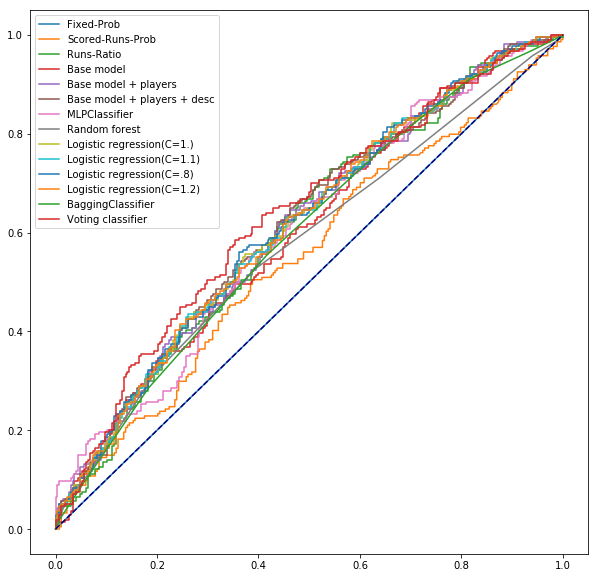

                          Model     Brier   ROC-AUC    PR-AUC  Accuracy
13            Voting classifier  0.243347  0.633021  0.569876  0.603734
4          Base model + players  0.258828  0.611086  0.557370  0.580913
5   Base model + players + desc  0.257848  0.616613  0.558749  0.580913
9    Logistic regression(C=1.1)  0.290070  0.613492  0.556241  0.580913
6                 MLPClassifier  0.257049  0.604652  0.572346  0.578838
8     Logistic regression(C=1.)  0.286902  0.614050  0.557416  0.578838
11   Logistic regression(C=1.2)  0.292629  0.612847  0.555413  0.578838
2                    Runs-Ratio  0.243023  0.605890  0.533125  0.576763
10    Logistic regression(C=.8)  0.280700  0.615637  0.558859  0.576763
7                 Random forest  0.260436  0.576876  0.510084  0.570539
12            BaggingClassifier  0.253029  0.595655  0.512123  0.570539
3                    Base model  0.242385  0.600746  0.533794  0.553942
1              Scored-Runs-Prob  0.247954  0.549562  0.495477  0

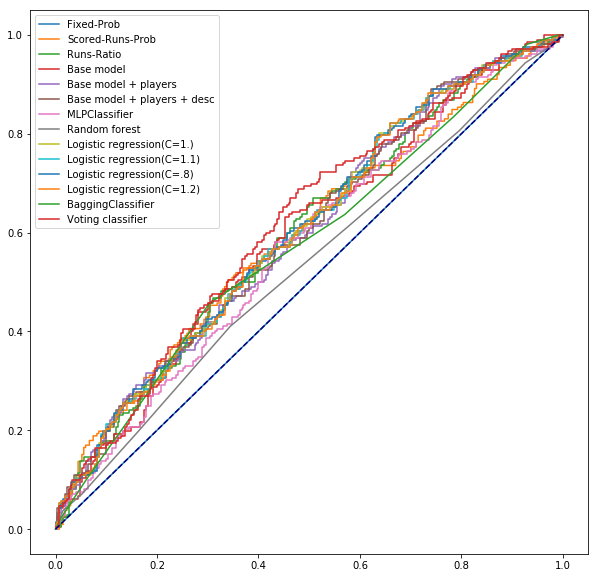

                          Model     Brier   ROC-AUC    PR-AUC  Accuracy
13            Voting classifier  0.251184  0.616632  0.546671  0.591286
9    Logistic regression(C=1.1)  0.297863  0.601275  0.541776  0.578838
12            BaggingClassifier  0.252199  0.575568  0.500444  0.578838
10    Logistic regression(C=.8)  0.286475  0.604018  0.545302  0.576763
11   Logistic regression(C=1.2)  0.300878  0.600804  0.541087  0.576763
3                    Base model  0.240091  0.593501  0.526566  0.574689
8     Logistic regression(C=1.)  0.294319  0.602131  0.543257  0.572614
2                    Runs-Ratio  0.243808  0.597449  0.526065  0.570539
5   Base model + players + desc  0.294676  0.597240  0.544030  0.570539
1              Scored-Runs-Prob  0.245803  0.594410  0.531654  0.566390
4          Base model + players  0.305085  0.596017  0.537383  0.562241
6                 MLPClassifier  0.317835  0.573096  0.501802  0.560166
7                 Random forest  0.266307  0.532154  0.472075  0

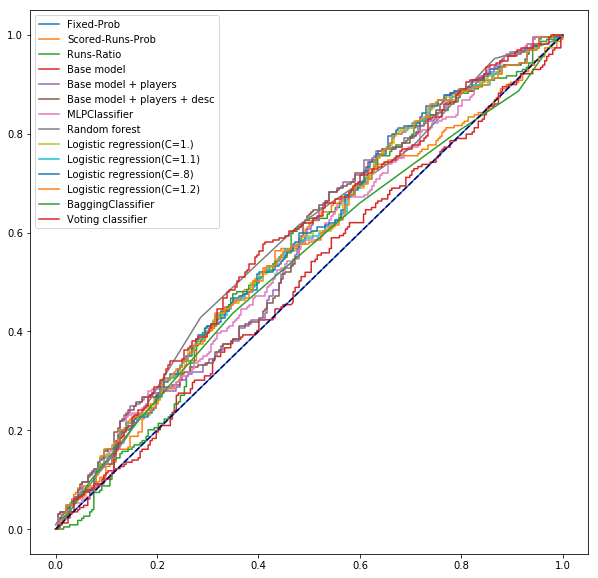

                          Model     Brier   ROC-AUC    PR-AUC  Accuracy
7                 Random forest  0.254553  0.585265  0.539519  0.577963
13            Voting classifier  0.253626  0.582883  0.533033  0.563410
2                    Runs-Ratio  0.248182  0.561187  0.499564  0.559252
11   Logistic regression(C=1.2)  0.313620  0.574080  0.533433  0.559252
9    Logistic regression(C=1.1)  0.310856  0.574686  0.533598  0.555094
1              Scored-Runs-Prob  0.248198  0.557505  0.527546  0.553015
8     Logistic regression(C=1.)  0.307430  0.575986  0.534090  0.550936
10    Logistic regression(C=.8)  0.299899  0.577840  0.535717  0.548857
12            BaggingClassifier  0.270166  0.541944  0.509984  0.548857
6                 MLPClassifier  0.265655  0.561187  0.527549  0.538462
5   Base model + players + desc  0.250750  0.569765  0.539383  0.534304
4          Base model + players  0.251452  0.568951  0.538001  0.532225
3                    Base model  0.256450  0.507053  0.483671  0

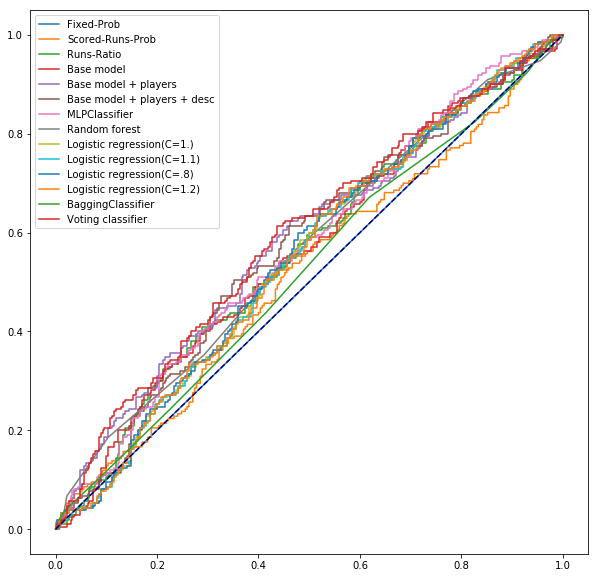

                          Model     Brier   ROC-AUC    PR-AUC  Accuracy
13            Voting classifier  0.248485  0.592487  0.521873  0.577083
4          Base model + players  0.249676  0.581623  0.520636  0.575000
5   Base model + players + desc  0.277625  0.569806  0.494154  0.568750
7                 Random forest  0.259833  0.562954  0.492824  0.552083
3                    Base model  0.248306  0.560406  0.480716  0.550000
10    Logistic regression(C=.8)  0.324184  0.552716  0.472408  0.550000
8     Logistic regression(C=1.)  0.332639  0.550423  0.469095  0.543750
2                    Runs-Ratio  0.247584  0.559277  0.478408  0.539583
11   Logistic regression(C=1.2)  0.339595  0.549806  0.468653  0.537500
9    Logistic regression(C=1.1)  0.336316  0.550106  0.468704  0.535417
1              Scored-Runs-Prob  0.249405  0.517522  0.466435  0.533333
12            BaggingClassifier  0.277938  0.520520  0.458879  0.520833
6                 MLPClassifier  0.379481  0.568783  0.502532  0

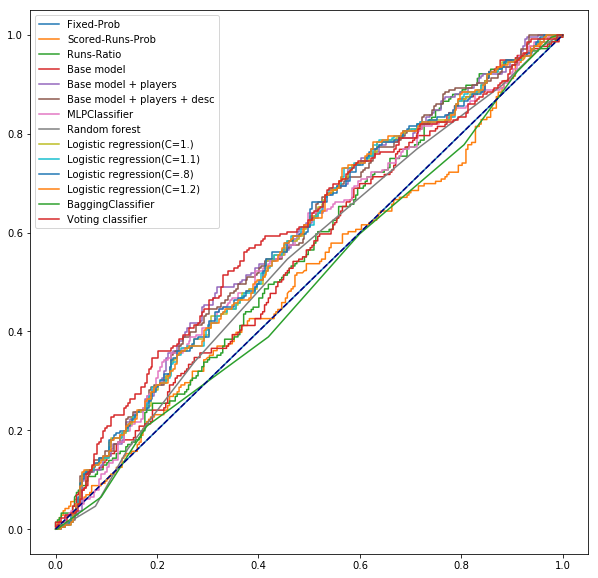

                          Model     Brier   ROC-AUC    PR-AUC  Accuracy
13            Voting classifier  0.248632  0.599424  0.534314  0.587992
11   Logistic regression(C=1.2)  0.317623  0.583680  0.505860  0.563147
9    Logistic regression(C=1.1)  0.314451  0.583715  0.505676  0.561077
8     Logistic regression(C=1.)  0.311405  0.583403  0.505842  0.559006
4          Base model + players  0.268993  0.592679  0.511408  0.556936
10    Logistic regression(C=.8)  0.304249  0.584599  0.507453  0.556936
5   Base model + players + desc  0.271702  0.590217  0.512194  0.552795
7                 Random forest  0.266832  0.544666  0.468658  0.552795
6                 MLPClassifier  0.293671  0.571941  0.496793  0.548654
2                    Runs-Ratio  0.247613  0.552911  0.497399  0.532091
3                    Base model  0.246160  0.551264  0.494146  0.530021
1              Scored-Runs-Prob  0.249794  0.509398  0.469294  0.513458
12            BaggingClassifier  0.281615  0.493472  0.442902  0

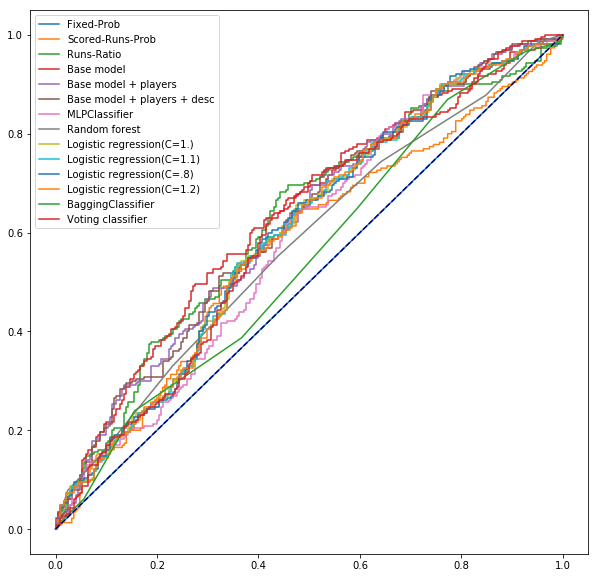

                          Model     Brier   ROC-AUC    PR-AUC  Accuracy
2                    Runs-Ratio  0.241169  0.623818  0.595875  0.598753
4          Base model + players  0.238988  0.620405  0.587704  0.584200
11   Logistic regression(C=1.2)  0.295101  0.598666  0.563845  0.584200
8     Logistic regression(C=1.)  0.289055  0.600468  0.566576  0.582121
5   Base model + players + desc  0.238778  0.621912  0.587786  0.580042
9    Logistic regression(C=1.1)  0.292002  0.599532  0.565416  0.580042
10    Logistic regression(C=.8)  0.282267  0.601386  0.566858  0.580042
1              Scored-Runs-Prob  0.247395  0.571315  0.534995  0.573805
3                    Base model  0.241448  0.635822  0.610647  0.561331
7                 Random forest  0.255343  0.577637  0.546773  0.559252
13            Voting classifier  0.247717  0.602148  0.556604  0.540541
6                 MLPClassifier  0.321059  0.585328  0.547290  0.528067
12            BaggingClassifier  0.261123  0.549221  0.515076  0

In [164]:
preds_per_model = {}
all_y = []

for year, season in season_data:
    print('Season year: ', year)
    _, sess_predicts, sess_res = season_report(season, roc_visualization=True)
    
    preds_per_model = {m: preds_per_model.get(m, []) + list(preds)
                   for m, preds in sess_predicts}
    
    all_y += list(sess_res)
    print()

Plotting all seasons report

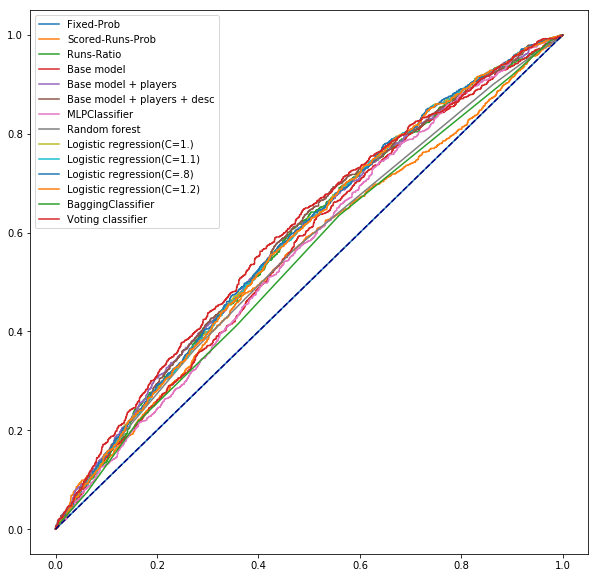

,Model,Brier,ROC-AUC,PR-AUC,Accuracy
13,Voting classifier,0.248831,0.599508,0.537567,0.577362
11,Logistic regression(C=1.2),0.309894,0.585816,0.518365,0.566632
4,Base model + players,0.262193,0.587644,0.528668,0.565247
9,Logistic regression(C=1.1),0.306912,0.586456,0.519024,0.565247
10,Logistic regression(C=.8),0.296283,0.588802,0.521659,0.564901
5,Base model + players + desc,0.265238,0.589295,0.528000,0.564555
8,Logistic regression(C=1.),0.303611,0.587161,0.519922,0.564555
2,Runs-Ratio,0.245229,0.584253,0.520360,0.562825
7,Random forest,0.260557,0.561927,0.501520,0.561440
3,Base model,0.245803,0.568090,0.506757,0.548287


In [165]:
all_seasons_results = [(k,
            metrics.brier_score_loss(all_y, preds),
            metrics.roc_auc_score(all_y, preds),
            metrics.average_precision_score(all_y, preds),
            metrics.accuracy_score(all_y, np.asarray(preds) > 0.5))
            for k, preds in preds_per_model.items()]

df_res = pd.DataFrame(all_seasons_results, columns=['Model', 'Brier', 'ROC-AUC', 'PR-AUC', 'Accuracy'])

# Plot the ROC curves
plt.figure(figsize=(10, 10))
for method, preds in preds_per_model.items():
    fpr, tpr, _ = metrics.roc_curve(all_y, preds)

    plt.plot(fpr, tpr, label=method)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc='best')
plt.show()

df_res.sort_values('Accuracy', ascending=False)

# Base lines

In [40]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline

features = ['home-prob', 'home-pos-runs', 'home-neg-runs', 'visitor-pos-runs', 'visitor-neg-runs',
            'home-games-played', 'visitor-games-played', 'home-win', 'visitor-win',
            #'home-rest-days', 'visitor-rest-days'
           ]

X_ = Xpreproc[features].as_matrix()
y_ = y > 0

ntrain = int(0.8 * len(X_))

clf = make_pipeline(Imputer(), LogisticRegression())# .fit(X_[: ntrain], y_[: ntrain])
preds = cross_val_predict(clf, X_, y_, cv=5)# clf.predict_proba(X_[ntrain:])[:, 1]

### Model Performance

In [41]:
from sklearn import metrics

ytest = y_#[ntrain:]

results = [('Baseline',
            metrics.roc_auc_score(ytest, Xpreproc['home-prob'].values),#[ntrain:]),
            metrics.average_precision_score(ytest, Xpreproc['home-prob'].values), #[ntrain:]),
            metrics.accuracy_score(ytest, Xpreproc['home-prob'].values > 0.5)#[ntrain:] > 0.5),
            ),
            ('Model',
             metrics.roc_auc_score(ytest, preds),
             metrics.average_precision_score(ytest, preds),
             metrics.accuracy_score(ytest, preds),
             )
            ]

df_res = pd.DataFrame(results, columns=['Model', 'ROC-AUC', 'PR-AUC', 'Accuracy'])
df_res

,Model,ROC-AUC,PR-AUC,Accuracy
0,Baseline,0.535195,0.477528,0.537500
1,Model,0.529530,0.473687,0.555417
